# Capstone Webscrapping using BeautifulSoup

This notebook contains guidances & tasks on the data processing for the application

## Background

During the pandemic, people are struggling of thinking what to do to kill time and boredom. Of course, there are multiple ways of killing time, and one of the best way to do it is by watching movies. There is a little problem however, that people do not know what movies to watch. Thus, we would like to give an analysis on the most popular movies in 2021. This will give people an idea of what movie to watch in 2021.

The data used to rank movie's popularity is retrieved from [imdb](https://www.imdb.com/search/title/?release_date=2021-01-01,2021-12-31) website using [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library. For each movie, we will retrieve the `Title`, `IMDB Rating`, `Metascore`, and `Votes` to make a movie ranking list.

## Dependencies

Some libraries that needs to be installed for this notebook:

* BeautifulSoup
* Requests
* Pandas
* Matplotlib

The packages are already included in the `requirements.txt` file that is already provided.

## Requesting the Data and Creating a BeautifulSoup

Let's begin with requesting the web from the site with `get` method.

In [1]:
import requests

url_get = requests.get('https://www.imdb.com/search/title/?release_date=2021-01-01,2021-12-31')

To visualize what exactly you get from the `request.get`, we can use .content to see what we exactly get, in here I slice it so it won't make our screen full of the html we get from the page. You can delete the slicing if you want to see what we fully get.

In [2]:
url_get.content[1:500]

b'\n<!DOCTYPE html>\n<html\n    xmlns:og="http://ogp.me/ns#"\n    xmlns:fb="http://www.facebook.com/2008/fbml">\n    <head>\n         \n        <meta charset="utf-8">\n        <meta http-equiv="X-UA-Compatible" content="IE=edge">\n\n    <meta name="apple-itunes-app" content="app-id=342792525, app-argument=imdb:///?src=mdot">\n\n\n\n        <script type="text/javascript">var IMDbTimer={starttime: new Date().getTime(),pt:\'java\'};</script>\n\n<script>\n    if (typeof uet == \'function\') {\n      uet("bb", "LoadTitle",'

As we can see we get a very unstructured and complex html, which actually contains the codes needed to show the webpages on your web browser. But we as a human is still confused of what and where we can use that piece of code, so here is where we use the BeautifulSoup. Beautiful soup class will result in a a BeautifulSoup object. Beautiful Soup transforms a complex HTML document into a complex tree of Python objects. 

Let's make Beautiful soup object and feel free to explore the object here.

In [3]:
from bs4 import BeautifulSoup 

soup = BeautifulSoup(url_get.content, "html.parser")

In [4]:
print(soup.prettify()[1:500])

!DOCTYPE html>
<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
 <head>
  <meta charset="utf-8"/>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="app-id=342792525, app-argument=imdb:///?src=mdot" name="apple-itunes-app"/>
  <script type="text/javascript">
   var IMDbTimer={starttime: new Date().getTime(),pt:'java'};
  </script>
  <script>
   if (typeof uet == 'function') {
      uet("bb", "LoadTitle", {wb: 1});
    }
  </script>
  <scrip


## Finding the right key to scrap the data & Extracting the right information

By inspecting the website, we know that the movie list is actually served within `<div class="lister-list">` table.

In [5]:
table = soup.find('div', attrs = {'class':'lister-list'})
print(table.prettify()[1:500])

div class="lister-list">
 <div class="lister-item mode-advanced">
  <div class="lister-top-right">
   <div class="ribbonize" data-caller="filmosearch" data-tconst="tt9140554">
   </div>
  </div>
  <div class="lister-item-image float-left">
   <a href="/title/tt9140554/">
    <img alt="Loki" class="loadlate" data-tconst="tt9140554" height="98" loadlate="https://m.media-amazon.com/images/M/MV5BNTkwOTE1ZDYtODQ3Yy00YTYwLTg0YWQtYmVkNmFjNGZlYmRiXkEyXkFqcGdeQXVyNTc4MjczMTM@._V1_UX67_CR0,0,67,98_AL_.jp


Inspecting the website even further, we know that every movie has their own container named `<div class ="lister-item mode-advanced">`. So we can say that every movie is an item (or a row) within the table. Originally, we want to access:

* `Title`
* `IMDB Rating`
* `Metascore`
* `Votes`

From each movie. So first, we will find all the "row" (every movie) using BeautifulSoup, and then iterate over all of it while extracting the necessary elements.

In [6]:
row = table.find_all('div', attrs = {'class':'lister-item mode-advanced'})
row_length = len(row)

In [7]:
row_length

50

Note that each page only displays 50 movies, while there are 176.240 movies available in the site. I personally think that 50 data is too little, so I am going to extract 1.000 movies data from the site. By inspecting the site, we can know that the link to each page has a similar pattern, which is 

> `https://www.imdb.com/search/title/?release_date=2021-01-01,2021-12-31&start=<title_number>&ref_=adv_prv`

with `<title_number>` being the first movie title number to be displayed in the page. I decided to extract 1.000 movies information because the page pattern only matches for the first 10.000 movies title, while the rest contains unique codes in the link. And for the time factor, extracting all 10.000 movies is just too slow, so I will extract only 1.000 movies.

So first, I need a function to extract all 4 informations we want (title, ratings, etc) into a single list, given that we are already provided with a list of movies container. I will provide some explanations about some commands in the function.

### Creating Functions to Extract Information Given a List of Movies Container

***Important Note:*** Some elements we want to extract are not provided by the website, there are a lot of movies which rating, metascore, and votes are not provided. So whenever we meet the case, we will replace it with 0

In [8]:
def extract_page (output_list, row):
    
    """This function receives a list of movie containers and returns the Title, IMDB Rating,
    Metascore, and Votes for each movie. By inspecting the IMDB website, we know that every
    container always has the movie title, but not necessarily contains the Rating, Metascore,
    nor Votes. So we have to check whether each container contains those 3 optional elements or not.
    If the information is not provided, we will replace it with 0"""
    
    #Getting the number of movies from the lists
    row_length = len(row)
    
    #iterating over all movies
    for i in range(row_length):
        title = row[i].find('h3').find('a').text   #Extract the title
        rating_div = row[i].find('div', attrs = {'class':'ratings-bar'})   #Extract the rating container
        
        if rating_div == None:   #Checking if ratings are provided by the website
            rating = 0
            metascore = 0

        else:
            rating = rating_div.find('strong')   #Extract the rating
            if rating == None:   #Some ratings are not provided
                rating = 0
            else:
                rating = rating.text
            
            metascore = rating_div.find('span', attrs = {'class':'metascore'})   #Extract the metascore
            if metascore == None:   #Some metascores are not provided
                metascore = 0
            else:
                metascore = metascore.text.strip()   
                #The metascores are returned in an untidy format (contains white spaces)

        votes = row[i].find('span', attrs = {'name' : 'nv'})
        
        if votes == None:   #Some votes are not provided
            votes = 0
        else:
            votes = votes.text

        output_list.append((title, rating, metascore, votes))

In [9]:
# Checking whether the function is working as expected

temp = []
extract_page(temp, row)

print(temp[:5])
print('\nNumber of Movies Extracted:', len(temp))

[('Loki', '8.9', 0, '67,743'), ('The Tomorrow War', '6.7', '45', '66,401'), ('Sex/Life', '5.6', 0, '5,597'), ('F9', '5.5', '58', '27,090'), ('The Many Saints of Newark', 0, 0, 0)]

Number of Movies Extracted: 50


We see that our function returns the list consisting 4 information about 50 movies. We can proceed to use it to extract 1.000 movies information from the website.

### Extracting 1,000 Movies Title From IMDB Website

We want to extract movies data from multiple pages, so we will need to make multiple requests and iterate over them. Our workflow is:

1. Make a request to the page
2. Pass the content of the page to BeautifulSoup
3. Find all movie containers in the page
4. Extract the Title, Rating, Metascore, and Votes for each movie
5. Save the extracted information into a list
6. Make a request to another page and repeat step 2-5

In [10]:
temp = []  #Create a list that will contain all informations

for i in range(1, 1000, 50):   #Iterate over pages
    url_get = requests.get('https://www.imdb.com/search/title/?release_date=2021-01-01,2021-12-31&start=' + 
                           str(i) + '&ref_=adv_prv')   #Make a request to each page
    
    soup = BeautifulSoup(url_get.content, "html.parser")
    
    row = soup.find_all('div', attrs = {'class':'lister-item mode-advanced'})   #Get each movie container
    
    extract_page (temp, row)   #Extract the information

In [11]:
print(temp[:5])
print('\nNumber of Movies Extracted:', len(temp))

[('Loki', '8.9', 0, '67,743'), ('The Tomorrow War', '6.7', '45', '66,401'), ('Sex/Life', '5.6', 0, '5,597'), ('F9', '5.5', '58', '27,090'), ('The Many Saints of Newark', 0, 0, 0)]

Number of Movies Extracted: 1000


We have successfully extracted data from 1.000 movies. You may check the `temp` variable by removing the slicing.

## Creating data frame & Data wrangling

Put the array into a dataframe

In [12]:
import pandas as pd

df = pd.DataFrame(temp, columns = ('title', 'imdb_rating', 'metascore', 'votes'))
df.head()

,title,imdb_rating,metascore,votes
0,Loki,8.9,0,"67,743"
1,The Tomorrow War,6.7,45,"66,401"
2,Sex/Life,5.6,0,"5,597"
3,F9,5.5,58,"27,090"
4,The Many Saints of Newark,0,0,0


Some useful information about the variables:

* `imdb_rating`: Aggregated and summarized IMDB registered user's rating.

* `metascore`: Metascore is considered the rating of a film. Scores are assigned to movie's reviews of large group of the world's most respected critics, and weighted average are applied to summarize their opinions range. The higher the Metascore, the more positive reviews a movie has.

* `votes`: Users' votes

### Data Wrangling

Before we analyze and visualize the data, we need to clean it. So, from the process of extracting the data, we already know that there is no missing value in the DataFrame, since we replace any unavailable information with 0. However, all information we have extracted is of `string` type. So, let's check the dtypes first.

In [13]:
df.dtypes

title          object
imdb_rating    object
metascore      object
votes          object
dtype: object

Let's clean the data in each columns and convert them

* imdb_rating: float
* metascore: int
* votes: int

`imdb_rating` and `metascore` can be converted directly. But note that all data in the `votes` column has `,`, so we need to remove it before converting to integer. We will use `.str.replace()` method to remove the `,` in the votes column.

In [14]:
df['imdb_rating'] = df['imdb_rating'].astype(float)
df['metascore'] = df['metascore'].astype(int)
df['votes'] = df['votes'].str.replace(',', '')

In [15]:
df.head()

,title,imdb_rating,metascore,votes
0,Loki,8.9,0,67743
1,The Tomorrow War,6.7,45,66401
2,Sex/Life,5.6,0,5597
3,F9,5.5,58,27090
4,The Many Saints of Newark,0.0,0,NaN


Now our data has missing values. Let's replace them back with 0. Then we will be able to convert `votes` column into `integer` type and check whether each columns has the right data types.

In [16]:
df.fillna(0, inplace = True)
df['votes'] = df['votes'].astype(int)

In [17]:
df.dtypes

title           object
imdb_rating    float64
metascore        int32
votes            int32
dtype: object

Finally, setting the title as the index of each row.

In [18]:
df = df.set_index('title')

### Exploring the Data

So I want to explore some things from this data: 

* Which columns should I use to determine which is the most popular Movie?

* Are there any relations between imdb_rating & votes?

* What are the 7 most popular movie in 2021?

First, let's try to see whether there is a relation between imdb_rating and votes by using scatter plot. Since there are many movies with 0 rating and votes, we will exclude that first. Then we will normalize the rating and votes before plotting because of the difference between their ranges.

$$ Normalization formula: \frac{x - min}{max - min} $$

In [19]:
df_norm = df[(df['imdb_rating'] != 0) & (df['votes'] != 0)].copy()

In [20]:
imdb_min = df_norm['imdb_rating'].min()
imdb_range = df_norm['imdb_rating'].max() - imdb_min

df_norm['imdb_rating'] = (df_norm['imdb_rating'] - imdb_min) / imdb_range

In [21]:
vote_min = df_norm['votes'].min()
vote_range = df_norm['votes'].max() - vote_min

df_norm['votes'] = (df_norm['votes'] - vote_min) / vote_range

<AxesSubplot:xlabel='imdb_rating', ylabel='votes'>

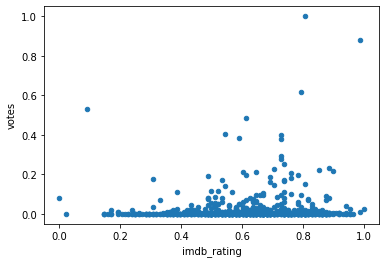

In [22]:
df_norm.plot.scatter(x = 'imdb_rating', y = 'votes')

It seems that the imdb_rating and votes are not correlated. Metascore is said to be the score given by world's most respected critics. So I think that might be a good metric in determining the movie rank. Let's check how many data are there without metascore.

In [23]:
print('Number of movies with no metascore:', df[df['metascore'] == 0].shape[0])

Number of movies with no metascore: 847


Out of 1000 movies, there are actually 848 movies without metascore. So, I will not use it as a metric to rank the movies. imdb_rating might be a good alternative metric, but I do not know exactly how they calculate it. The website says that it is a weighted average, but if that is the case, then we will never know how many people in total have watched and rated it. So, I personally think votes is the best metric to use.

In [24]:
# Set dataframe to the required format for plotting

df_top = df[['votes']].sort_values(by = 'votes', ascending = False)
df_top.head(7)

,votes
title,
Zack Snyder's Justice League,309982
Aspirants,273009
WandaVision,190842
Radhe,163997
Godzilla vs. Kong,150158
Army of the Dead,125171
The Falcon and the Winter Soldier,123181


Text(0.5, 0, 'Votes')

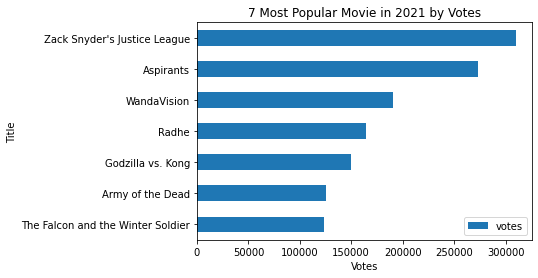

In [25]:
ax = df_top.head(7).plot(kind = 'barh')
ax.invert_yaxis()   #We want to see the most popular title on top
ax.set_title('7 Most Popular Movie in 2021 by Votes')
ax.set_ylabel('Title')
ax.set_xlabel('Votes')

### Implementing your webscrapping to the flask dashboard

- Copy paste all of your web scrapping process to the desired position on the `app.py`
- Changing the title of the dasboard at `index.html`

## Analysis and Conclusion

1. The most popular movie in 2021, ranked by votes is Zack Snyder's Justice League with over **309k votes**. The $2^{nd}$ to $7^{th}$ most popular movies are:

  * Aspirants (272k votes)
  * WandaVision (190k votes)
  * Radhe (163k votes)
  * Godzilla vs. Kong (149k votes)
  * Army of the Dead (124k votes)
  * The Falcon and the Winter Soldier (122k votes)
  
2. Even though IMDB Rating is said to be an aggregated and summarized IMDB registered user's rating, it is not strongly correlated to the number of user votes

3. IMDB Rating might not be a good metric for ranking the movies because there might be a case where only a few people watched it so the movie gets a high rating (not popular).

### Extra Challenge

We know that based on the number of users' votes, Zack Snyders' Justice League is the most popular movie in 2021. But considering that metascore is the best metric for ranking movies, I would like to know what is the best movie in 2021 according to the large group of world's most respected critics. Furthermore, I would also like to compare the rating and metascore of the top 7 movies ranked by this way.

In [26]:
df_meta = df[['metascore', 'imdb_rating']].sort_values(by = 'metascore', ascending = False).copy()
df_meta.head(7)

,metascore,imdb_rating
title,,
"Summer of Soul (...Or, When the Revolution Could Not Be Televised)",96,8.3
The Fallout,86,7.9
Judas and the Black Messiah,85,7.5
In the Heights,84,7.5
Passing,84,7.1
The Sparks Brothers,81,8.1
Tina,81,8.0


I want to use bar plot, but then the difference of `imdb_rating`'s range and `metascore`'s range will make the plot messy. We know that the score that could be achieved by metascore is 0-100. To make it the same range as imdb_rating's (0-10) I will just divide the value by 10. And the top movie's title is too long, I'm going to cut it so the plot does not look messy.

In [27]:
df_meta['metascore'] = df_meta['metascore'] / 10
df_meta.rename(index = {'Summer of Soul (...Or, When the Revolution Could Not Be Televised)' : 
                        'Summer of Soul'}, inplace = True)

df_meta.head()

,metascore,imdb_rating
title,,
Summer of Soul,9.6,8.3
The Fallout,8.6,7.9
Judas and the Black Messiah,8.5,7.5
In the Heights,8.4,7.5
Passing,8.4,7.1


Plotting the data above

Text(0, 0.5, 'Movie Title')

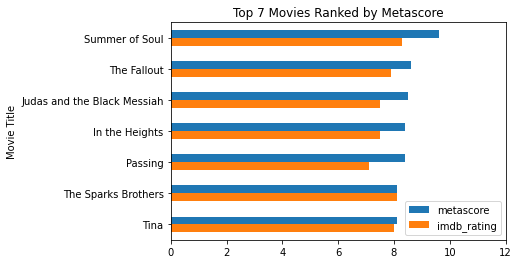

In [28]:
ax = df_meta.head(7).plot(kind = 'barh', legend = True)
ax.set_xticks(range(0, 14, 2), minor=False)
ax.legend(loc = 'lower right')
ax.invert_yaxis()

ax.set_title('Top 7 Movies Ranked by Metascore')
ax.set_ylabel('Movie Title')

**Notes**: we set_xticks to give some spaces for the legend. Originally, it would be over the bar.

#### Analisis and Conclusion

1. The most popular movie ranked by its metascore is Summer of Soul(...Or, When the Revolution Could Not Be Televised) with a metascore of 96. The  2𝑛𝑑  to  7𝑡ℎ  most popular movies ranked by their metascore are:
  * The Fallout
  * Judas and The Black Messiah
  * In the Heights
  * Passing
  * Tina
  * The Sparks Brothers
  
2. A High metascore does not necessarily imply high IMDB rating.